In [ ]:
# подключаем гугл-диск

from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.metrics import Accuracy, Precision, Recall, AUC, TrueNegatives, TruePositives, FalseNegatives, FalsePositives

import matplotlib.pyplot as plt

import PIL
from PIL import Image
import os

from sklearn.preprocessing import MinMaxScaler

def f1(y_true, y_pred):
    y_true = K.flatten(y_true)
    y_pred = K.flatten(y_pred)
    return 2 * (K.sum(y_true * y_pred)+ K.epsilon()) / (K.sum(y_true) + K.sum(y_pred) + K.epsilon())

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('AUC')
  plt.plot(hist['epoch'], hist['auc'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_auc'],
           label = 'Val Error')
  #plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('F1_score')
  plt.plot(hist['epoch'], hist['f1'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_f1'],
           label = 'Val Error')
  plt.legend()
  plt.show()

In [ ]:
data = pd.read_csv('/content/drive/My Drive/IMAGE_DATA_COR/DP_cor.csv', sep=';')
for i in [
    'trunk_st', 
    'LAD_st',
    'lcx_stenosis',
    'RCA_stenosis'
]:
    data[i] = data[i].apply(lambda x: 1 if x >= 50 else 0)

X = data.iloc[:,1:23]
scaler = MinMaxScaler(feature_range=(0, 1))
X[X.columns] = scaler.fit_transform(X[X.columns])
y1 = data.iloc[:,23:-1]

test = pd.read_csv('/content/drive/My Drive/IMAGE_DATA_COR/test_DL.csv', sep=';')
for i in [
    'trunk_st', 
    'LAD_st',
    'lcx_stenosis',
    'RCA_stenosis'
]:
    test[i] = test[i].apply(lambda x: 1 if x >= 50 else 0)
    
X_test = test.iloc[:,1:23]
scaler = MinMaxScaler(feature_range=(0, 1))
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])
y_test = test.iloc[:,23:-1]

data_image_test = []
for k in os.listdir('/content/drive/My Drive/IMAGE_DATA_COR/TEST-ECG'):
    if k.endswith('.jpg'):
        img = Image.open('/content/drive/My Drive/IMAGE_DATA_COR/TEST-ECG/'+k)
        #img = img.convert('L')
        img = img.resize((224, 224))
        data_image_test += [np.array(img) / 255.]
data_image = []
for k in os.listdir('/content/drive/My Drive/IMAGE_DATA_COR/ЭКГ'):
    if k.endswith('.jpg'):
        img = Image.open('/content/drive/My Drive/IMAGE_DATA_COR/ЭКГ/'+k)
        #img = img.convert('L')
        img = img.resize((224, 224))
        data_image += [np.array(img) / 255.]

In [ ]:
feature_extractor_url = 'https://tfhub.dev/tensorflow/efficientnet/b3/feature-vector/1'
hub_layer_1 = hub.KerasLayer(feature_extractor_url, input_shape=((224, 224)+ (3,)), trainable=True)

tf.keras.backend.clear_session()

input_1 = Input(shape=(224, 224, 3), name = "Input_image")
x = hub_layer_1(input_1)
#x = Dropout(0.8)(x)
#x = Dense(128, activation="elu")(x)
predictions = Dense(13, activation="sigmoid")(x)

mod = Model(inputs=input_1, outputs=predictions)

mod.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC', f1])
mod.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_image (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 1536)              10783528  
_________________________________________________________________
dense (Dense)                (None, 13)                19981     
Total params: 10,803,509
Trainable params: 10,716,213
Non-trainable params: 87,296
_________________________________________________________________


In [ ]:
batch_size = 50

history = mod.fit( 
np.array(data_image), y1,
batch_size = batch_size,
steps_per_epoch=2,     #len(data_image)//batch_size,
validation_split=0.1,
epochs=20,
shuffle=True,
verbose=1
)

Epoch 1/20
2/2 [==============================] - 3s 1s/step - loss: 0.8379 - auc: 0.5576 - f1: 0.3095 - val_loss: 0.9094 - val_auc: 0.3338 - val_f1: 0.2071
Epoch 2/20
2/2 [==============================] - 1s 366ms/step - loss: 0.6234 - auc: 0.9171 - f1: 0.4249 - val_loss: 0.8871 - val_auc: 0.3242 - val_f1: 0.2027
Epoch 3/20
2/2 [==============================] - 1s 381ms/step - loss: 0.4948 - auc: 0.9598 - f1: 0.5231 - val_loss: 0.8511 - val_auc: 0.3248 - val_f1: 0.1968
Epoch 4/20
2/2 [==============================] - 1s 371ms/step - loss: 0.3937 - auc: 0.9860 - f1: 0.6355 - val_loss: 0.7597 - val_auc: 0.3893 - val_f1: 0.1887
Epoch 5/20
2/2 [==============================] - 1s 362ms/step - loss: 0.3387 - auc: 0.9932 - f1: 0.7156 - val_loss: 0.7053 - val_auc: 0.4375 - val_f1: 0.1708
Epoch 6/20
2/2 [==============================] - 1s 361ms/step - loss: 0.3011 - auc: 0.9951 - f1: 0.7769 - val_loss: 0.7025 - val_auc: 0.4779 - val_f1: 0.1504
Epoch 7/20
2/2 [===========================

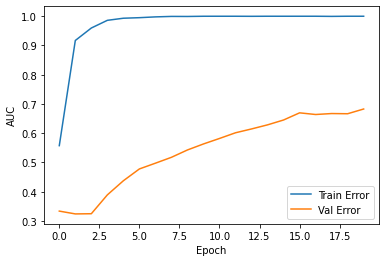

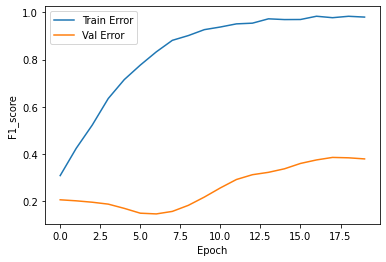

In [ ]:
plot_history(history)

In [ ]:
pred_2 = pd.DataFrame(mod.predict(np.array(data_image_test)) > 0.5, columns=y1.columns) * 1

for i in [
    Accuracy(),
    Precision(),
    Recall(),
    AUC(),
    TrueNegatives(),
    TruePositives(),
    FalseNegatives(),
    FalsePositives()
]:
    _ = i.update_state(y_test.values, pred_2)
    print(f'{i.name}: {"%0.2f" % i.result().numpy()}')
print('f1:', f1(y_test.values.astype('float32'), pred_2.astype('float32')).numpy())

accuracy: 0.87
precision: 0.75
recall: 0.68
auc: 0.80
true_negatives: 92.00
true_positives: 21.00
false_negatives: 10.00
false_positives: 7.00
f1: 0.7118644


In [ ]:
pred_3 = pd.DataFrame(mod.predict(np.array(np.array(data_image))) > 0.5, columns=y1.columns) * 1
sum(pred_3['LAD_st'])

3

In [ ]:
pred_3 = pd.DataFrame(mod.predict(np.array(np.array(data_image))) > 0.5, columns=y1.columns) * 1
sum(pred_3['RCA_sub_occ'])

1

In [ ]:
pred_2

,completed_stenting_or_AKSh,verified_coronary_atherosclerosis,trunk_st,trunk_sub_occ,LAD_occ,LAD_sub_occ,LAD_st,lcx_occ,lcx_sub_occ,lcx_stenosis,RCA_occ,RCA_sub_occ,RCA_stenosis
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0,0,0,1
2,1,1,0,0,0,0,0,0,0,0,0,0,1
3,0,1,0,0,0,0,0,0,0,0,0,0,1
4,1,1,0,0,0,0,1,0,0,0,0,0,1
5,1,1,0,0,0,0,0,0,0,0,0,0,1
6,0,1,0,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,1,0,0,0,0,0,1
8,1,1,0,0,0,0,0,0,0,0,0,0,1
9,1,1,0,0,0,0,1,0,0,0,0,0,1


In [ ]:
y_test

,completed_stenting_or_AKSh,verified_coronary_atherosclerosis,trunk_st,trunk_sub_occ,LAD_occ,LAD_sub_occ,LAD_st,lcx_occ,lcx_sub_occ,lcx_stenosis,RCA_occ,RCA_sub_occ,RCA_stenosis
0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,1,0,1,0
2,1,1,0,0,0,0,1,1,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,1,0,0,0,0,0,1
5,0,0,0,0,0,0,0,0,0,0,0,0,0
6,1,1,0,0,0,0,1,0,0,0,0,1,1
7,1,1,0,0,0,0,1,0,0,0,0,1,1
8,1,1,0,0,0,0,1,0,0,0,0,0,0
9,1,1,0,0,0,0,1,0,0,0,0,0,1
